In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.gridspec as gridspec
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl

In [15]:
N = 1
offer_p = np.arange(0.01,0.99,1.0/N)
# total_int_calls_minutes = pm.Uniform("total_int_calls_minutes", 0,800, size=N)
total_int_calls_minutes = pm.HalfNormal("total_int_calls_minutes", tau=1.0/10000, size=N)
intl_calls_price_per_min = pm.Lognormal("intl_calls_price_per_min",mu=0.0, tau=10.0, size=N)
total_intl_charged = pm.Lambda('total_intl_charged', lambda tm=total_int_calls_minutes, ppm=intl_calls_price_per_min: tm*ppm)

price_complaints_number = pm.Lambda('price_complaints_number', lambda t=total_intl_charged:  max(0.01,np.log(t/5)))


intl_pack_offer_p = pm.Uniform("intl_pack_offer_p", 0,1,size=N)
offered_intl_call_package = pm.Bernoulli("offered_intl_call_package", p=0.5, size=N)

agree_to_intl_calls_package_offer = pm.Lambda('agree_to_intl_calls_package_offer', \
                                              lambda offer=offered_intl_call_package, total_charged=total_intl_charged: \
                                             offer*(1.0/(1.0+np.exp(-np.sort(total_charged)/10.0+1.))))


churn_p = pm.Lambda('churn_p', lambda nc=price_complaints_number: 1.0-np.exp(-nc/2))
should_churn = pm.Bernoulli("should_churn",churn_p,size=N) 
has_intl_calls_package = pm.Bernoulli("has_intl_calls_package", p=agree_to_intl_calls_package_offer, size=N)
is_churned = pm.Lambda('is_churned', lambda should=should_churn, has_pck=has_intl_calls_package: ~has_pck & should)


In [13]:
model = pm.Model([total_int_calls_minutes, 
                  intl_calls_price_per_min, 
                  total_intl_charged, 
                  price_complaints_number, 
#                   intl_pack_offer_p,
                  offered_intl_call_package, 
                  agree_to_intl_calls_package_offer,
                  has_intl_calls_package,     
                  churn_p,
                  should_churn,
                  is_churned                  
                 ])

mcmc = pm.MCMC(model)
mcmc.sample(20000,500)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.1 sec

In [14]:
offered = mcmc.trace('offered_intl_call_package')[:,0]
has = mcmc.trace('has_intl_calls_package')[:,0]
churn = mcmc.trace('is_churned')[:,0]
churn_p = mcmc.trace('churn_p')[:]
# off_p = mcmc.trace('intl_pack_offer_p')[:,0]
price = mcmc.trace('intl_calls_price_per_min')[:,0]
total_calls = mcmc.trace('total_int_calls_minutes')[:,0]
complaints=mcmc.trace('price_complaints_number')[:]
charged = mcmc.trace('total_intl_charged')[:,0]




In [67]:
offered


array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

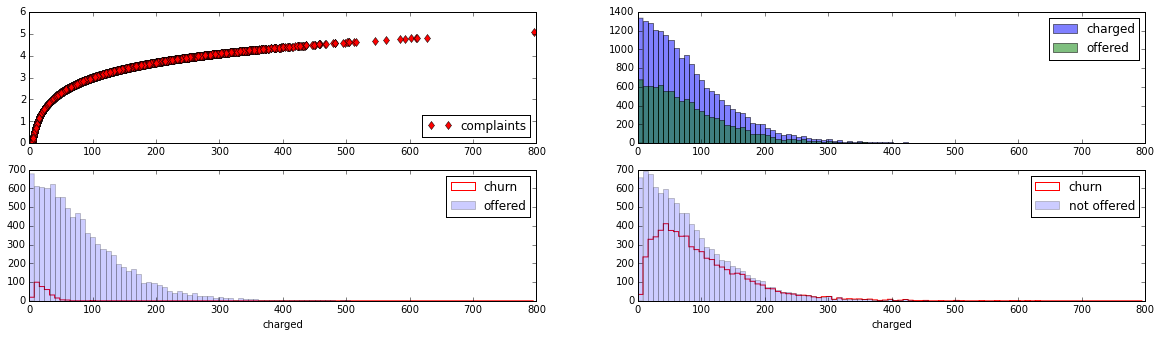

In [72]:
# histtype: 'bar', 'barstacked', 'step',  'stepfilled'
figsize(20, 8)
rows = 3
cols = 2
x = charged
bins = np.linspace(min(x), max(x),100)

plt.subplot(rows,cols,1)
plt.plot(charged,complaints,'rd',label='complaints')
plt.legend(loc='lower right')

plt.subplot(rows,cols,2)
plt.hist(x, bins=bins, alpha=0.5, label='charged')
ch_of =plt.hist(charged[offered], bins=bins, alpha=0.5, label='offered')
# plt.plot(charged, 
plt.legend(loc='upper right')

plt.subplot(rows,cols,3)
plt.hist(charged[churn & offered], bins=bins, alpha=1, label='churn',histtype='step', color='red')
plt.hist(charged[offered], bins=bins, alpha=0.2, label='offered',histtype='bar')
plt.legend(loc='upper right')
plt.xlabel("charged")

plt.subplot(rows,cols,4)
plt.hist(charged[churn & ~offered], bins=bins, alpha=1, label='churn', histtype='step', color='red')
ch_nof=plt.hist(charged[~offered], bins=bins, alpha=0.2, label='not offered',histtype='bar')
plt.legend(loc='upper right')
plt.xlabel("charged")


ch_of=np.histogram(charged[offered], bins=10)
ch_nof=np.histogram(charged[~offered], bins=10)





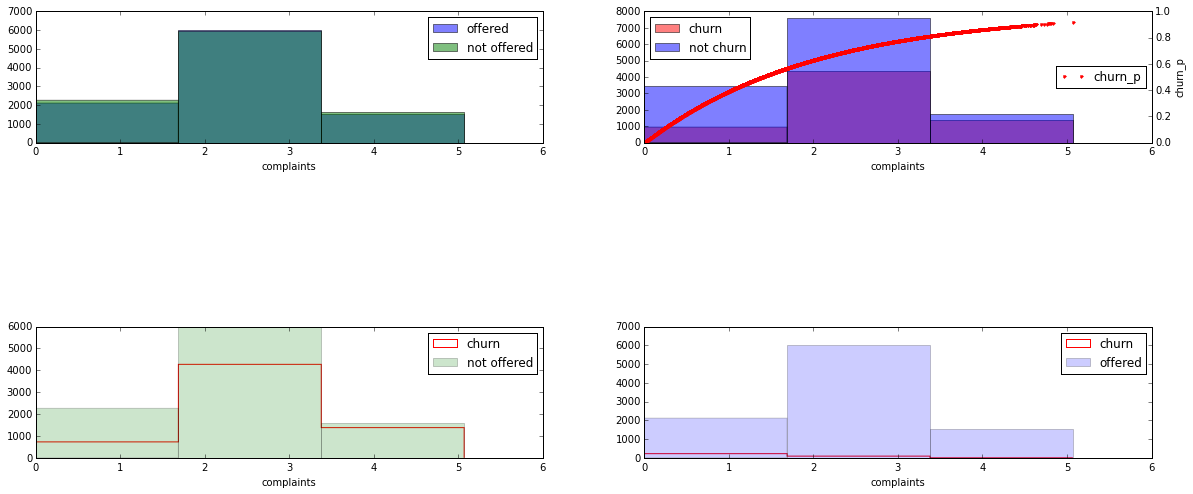

In [70]:
fsize = figsize(20, 8)
rows = 3
cols = 2
complaints_bins = np.linspace(0, max(complaints),4)

plt.subplot(rows,cols,1)
plt.hist(complaints[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
plt.hist(complaints[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
plt.xlabel("complaints")
plt.legend(loc='upper right')


ax1 = plt.subplot(rows,cols,2)
h1=ax1.hist(complaints[churn], bins=complaints_bins, alpha=0.5, label='churn', histtype='bar', color='red')
h2=ax1.hist(complaints[~churn], bins=complaints_bins, alpha=0.5, label='not churn',histtype='bar')
ax1.set_xlabel("complaints")
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
l1=ax2.plot(complaints, churn_p, '.r',label='churn_p')
ax2.set_ylabel('churn_p')
ax2.legend(loc='right')


plt.subplot(rows,cols,5)
plt.hist(complaints[churn & ~offered], bins=complaints_bins, alpha=1, label='churn', histtype='step', color='red')
plt.hist(complaints[~offered], bins=complaints_bins, alpha=0.2, label='not offered',histtype='bar', color='green')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,6)
plt.hist(complaints[churn & offered], bins=complaints_bins, alpha=1, label='churn', histtype='step', color='red')
plt.hist(complaints[offered], bins=complaints_bins, alpha=0.2, label='offered',histtype='bar')
plt.xlabel("complaints")
plt.legend(loc='upper right')




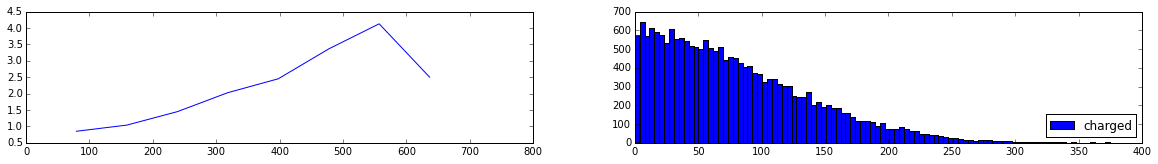

In [73]:
plt.subplot(rows,cols,5)
off_to_not_off =ch_nof[0].astype(float)/ch_of[0].astype(float)
plt.plot(ch_of[1][1:],off_to_not_off,'b',label='')
plt.legend(loc='lower right')


plt.subplot(rows,cols,6)
NN = len(charged)
# charges_space = np.linspace(min(charged), max(charged),NN)

# plt.plot(charges_space,np.sort(charged),'rd',label='charged')
tm = pm.rhalf_normal(tau=1.0/10000, size=NN)
ppm = pm.rlognormal(mu=0.0, tau=10.0, size=NN)
tch = tm*ppm

plt.hist(tm,100,label='charged')
plt.legend(loc='lower right')


